In [1]:
!nvidia-smi

Wed Dec 20 21:15:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.01                 Driver Version: 546.01       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0              13W /  40W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1. Импортируем библиотеки и данные

In [3]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import cv2
import os
import json
from random import choice
import torch
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from torchvision import models, transforms
import albumentations as A
from tqdm import tqdm
from ultralytics import YOLO
# Отключаем проверку
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Получаем список имён файлов
images_special_car = listdir('./Dataset/Spesial_car/') 
image_rest = listdir('./Dataset/Rest/')

# Переносим их в датафрейм
data_special_car = pd.DataFrame(images_special_car, columns=['src'])
data_rest = pd.DataFrame(image_rest, columns=['src'])

# Добавляем целевые признаки
data_special_car['label'] = 1 # Спец. авто
data_rest['label'] = 0 # Простые фотографии

# Объядиняем 
data = pd.concat([data_special_car, data_rest], ignore_index=True)
data # Посмотрим на получившийся датафрейм

,src,label
0,0000.jpg,1
1,0001.jpg,1
2,0002.png,1
3,0003.jpg,1
4,0004.png,1
...,...,...
1605,0911.jpg,0
1606,0912.jpg,0
1607,0913.jpg,0
1608,0914.jpg,0


In [4]:
data['label'].value_counts() / data.shape[0] * 100 # Распределение целевого признака

label
0    56.89441
1    43.10559
Name: count, dtype: float64

Можно заметить, что фотографий без спец авто больше в датасете

# 2. Аугментация фотографий и последующая их обработка

## 2.1. Описание правил аугментаций

In [5]:
# Описываем приёмы аугментации
transform1 = A.Compose([
    A.HorizontalFlip(p=0.5), # Отзеркаливание изображения
    A.RandomBrightnessContrast(p=0.25), # Изменение яркости ищображения
])
transform2 = A.Compose([
    A.HorizontalFlip(p=0.05), # Поворот по вертикали
    A.Blur(p=0.25) # Эффект размытия на изображении
])
transform3 = A.Compose([
     A.HorizontalFlip(p=0.5), # Отзеркаливание изображения
     A.CLAHE(p=0.25) # Увеличение резкости изоюбражения
])
transform4 = A.Compose([
    A.HorizontalFlip(p=0.05), # Поворот по вертикали
    A.ToGray() # Перевод изображения в чб изображение
])
transform5 = A.Compose([
    A.HorizontalFlip(p=0.5), # Поворот по вертикали
    A.RandomContrast(p=0.25) # Увеличение контарстности
])
transform6 = A.Compose([
    A.HorizontalFlip(p=0.05), # Поворот по вертикали
    A.JpegCompression(p=0.25) # Добавление шума на изображение
])

## 2.2. Обработка каждой фотографии и их аугментация

100%|██████████████████████████████████████████████████████████████████████████████| 1610/1610 [00:36<00:00, 43.79it/s]


CPU times: total: 28.2 s
Wall time: 43.7 s


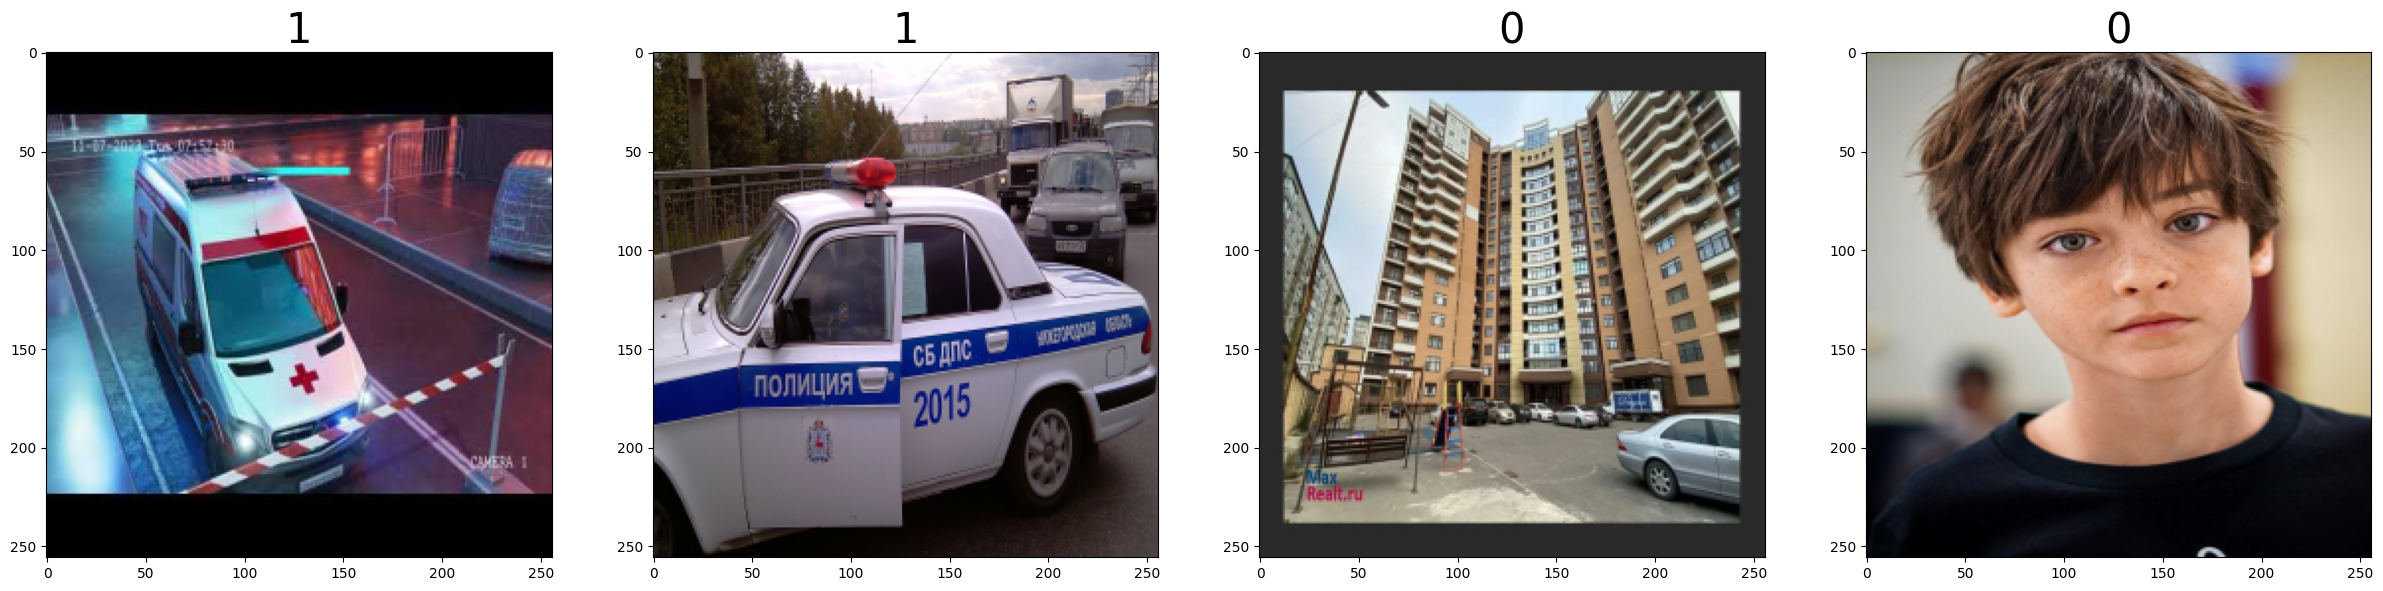

In [6]:
%%time
X = [] # Фотографии в формате матриц
y = [] # Классы фотографий
for i in tqdm(range(len(data))):
    image = data.loc[i,'src'] # Получим путь к изображению
    if (data.loc[i, 'label'] == 1): # Если на фотографии спец. авто
        image = cv2.imread('./Dataset/Spesial_car/'+image, cv2.IMREAD_COLOR) 
    else: # Если на фотографии не спец. авто
        image = cv2.imread('./Dataset/Rest/'+image, cv2.IMREAD_COLOR) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Перевеодим цветовую палитру фото с формата BGR в RGB 
    image = cv2.resize(image, dsize=(256, 256), interpolation=cv2.INTER_AREA); # Изменяем размерность изображения до 200x200
    X.append(image) # Добавляем в датасет

    # Производим аугментацию фотографий
    transform = None
    transform_old = None
    for _ in range(2):
        while True:
            transform = choice([transform1, transform2, transform3, transform4, transform5, transform6])
            if transforms != transform_old:
                transformed_image = transform(image=image)
                X.append(transformed_image["image"])
                transform_old = transform
                break
    # Добавление меток для изображений
    for _ in range(3):
        y.append(data.loc[i, 'label'])

# Нормализируем данные
X_torch = np.array(X)
X_torch = X_torch.astype('float32')
X_torch = X_torch / 255.0
X_torch = X_torch.reshape(-1,3, 256, 256)
y_torch = np.array(y).reshape(-1)

# Выведем пару примеров получившихся фотографий
fig, axes = plt.subplots(1, 4, figsize=(30,15))
for i in range(0, 4):
    axes[i].imshow(X[i*y_torch.size//4])
    axes[i].set_title(y[i*y_torch.size//4], fontsize=30)

In [7]:
print(f"Количество изоражений: {X_torch.shape[0]} | Количество меток {y_torch.size}")
print(f"Количество фотографий после аугментации увеличилось в {round(y_torch.size / data.shape[0], 3)} раз и составило {y_torch.size} изображения") # кол-во фото

Количество изоражений: 4830 | Количество меток 4830
Количество фотографий после аугментации увеличилось в 3.0 раз и составило 4830 изображения


# 3. Обучение нейросети
## 3.1. Формирование тренировочной и валидационной выборки, перевод данных в тензоры.

In [8]:
# Определим возможность обработки фото на GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [9]:
# Сформируем новую тренировчную и тестовую выборку
X_train, X_valid, y_train, y_valid = train_test_split(X_torch, y_torch, random_state=42)

In [10]:
# Переведём все данные в тензоры
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train)
X_valid_t = torch.from_numpy(X_valid).float()
y_valid_t = torch.from_numpy(y_valid)

# Формируем датасеты с выборками
train_dataset = TensorDataset(X_train_t, y_train_t)
valid_dataset = TensorDataset(X_valid_t, y_valid_t)
train_dataloader = DataLoader(train_dataset, batch_size=31)
valid_dataloader = DataLoader(valid_dataset, batch_size=32) 

# Словарь с выборками
loaders = {"train": train_dataloader, "valid": valid_dataloader}

## 3.2. Функции для обучения моделей

In [11]:
def trainNeuralNetwork(model, loaders, name_model, max_epochs, epoch_patience):
    '''
    Функция позволяет обучить модель нейросети, сохранить на компьютере веса и вернуть историю выполнения
    Input:
        model - модель нейросети
        loaders - словарь с выборками
        name_model - название модели
        max_epochs - максимальное количество эпох обучения
        epoch_patience - количество эпох для ранней остановки обучения (борьба с переобучением)
    Output:
        best_model_roc - истинные и предсказанные значения у лучшей модели 
        loss_history - история ощибки по эпохам при обучении модели
        epoch_erly_stopping - эпоха на которой произошла ранняя остановка модели
        best_model_accuracy - точность  у лучшего экземпляра модели
        best_model_loss - потеря у лучшего экземпляра модели
    '''
    print(f'Training of {name_model} neural network architecture')
    criterion = torch.nn.CrossEntropyLoss() # Вычесление ошибки
    optimizer = torch.optim.Adam(model.parameters()) # Вычесление градиента ошибок
    best_model = model # Лучшая образ модель
    best_model_loss = np.Inf # Ошибка у лучшей модели
    best_model_accuracy = 0 # Точность у лучшей модели  
    epoch_erly_stopping = 0 # Эпоха ранней остановки
    flag = False 
    col_not_best = 0 # Количество эпох без изменений
    loss_history = {"train": [], "valid": []} # История потерь модели на каждой эпохе 
    best_model_roc = {"correct": [], "preds": []}
    train_losses = [] # Ошибка на тренировочной выборке для каждой картинки
    valid_losses = [] # Ошибка на валидационной выборке для каждой картинки
    start_time = datetime.now() # Время начало работы
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            roc = {"correct": [], "preds": []}
            for x_batch, y_batch in dataloader:
                # Переносим на устройсво данные
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad() # Обнуляем градиенты ошибок
                    outp = model(x_batch) # Получаем ответы от модели
                else:
                    model.eval() # Ставим модель на обучение 
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1) # Softmax, получаем класс
                correct = (preds == y_batch).sum() # Кол-во правильных ответов
                all = preds.size(0) # Кол-во всех ответов
                epoch_correct += correct.item() # Кол-во фото корректно распознанных
                epoch_all += all # Общее количество фото 
                loss = criterion(outp, y_batch) # Вычисляем градиети
                if k == "train":
                    train_losses.append(loss.item()) # Добавляем ошибку для каждой фотографии
                    loss.backward()
                    optimizer.step()
                else:
                    roc["correct"].append([i.item() for i in y_batch])
                    roc["preds"].append([i.item() for i in preds])
                    valid_losses.append(loss.item()) # Добавляем ошибку для каждой фотографии
                    
            if k == "valid":
                # Вычисление средневзвешенное значения на выборках
                train_loss = np.average(train_losses) 
                valid_loss = np.average(valid_losses) 
                
                # Сохраняем средневзвешенную ошибки в историю
                loss_history["train"].append(abs(train_loss))
                loss_history["valid"].append(abs(valid_loss))
                print(f"[{epoch+1:>3}/{max_epochs:>3}] loss train: {abs(train_loss):.5f} | loss valid: {abs(valid_loss):.5f}")

                # Проверка на уменьшение ошибки нейросети на валидации
                if abs(round(best_model_loss, 5)) > abs(round(valid_loss, 5)):
                    # Сохранение информации о модели и её веса
                    col_not_best = 0 
                    best_model = model
                    epoch_erly_stopping = epoch
                    best_model_accuracy = epoch_correct/epoch_all 
                    best_model_roc = roc
                    torch.save(best_model, f"checkpoint_{name_model}.pt")
                    print(f"Validation loss decreased ({abs(best_model_loss):.5f} --> {abs(valid_loss):.5f}).  Saving model ...")
                    best_model_loss = abs(valid_loss)
                           
                else:
                    # Если X количество эпох нет прогресса, то останавливаем обучение
                    if col_not_best + 1 >= epoch_patience:
                        print("Early stopping!")
                        flag = True
                        break
                    else:
                        col_not_best += 1
                        print(f"EarlyStopping counter: {col_not_best} out of {epoch_patience}")    
        if flag:
            break
    roc = {'correct': [], 'preds': []}
    for sampling in ['correct', 'preds']:
        for index in range(len(best_model_roc[sampling])):
            for item in best_model_roc[sampling][index]:
                roc[sampling].append(item)
    best_model_roc = roc
    torch.save(best_model, f"{name_model}.pth") # Сохранение полной модели на компьютере
    print(f'Program execution time: {datetime.now() - start_time}')
    return best_model_roc, loss_history, epoch_erly_stopping, best_model_accuracy, best_model_loss

In [12]:
def visualizationLearning(name_model, epoch_stopping, roc, loss_history ):
    '''
    Функция позводяет визуализировать историю обучения модели нейросети и показать раннюю ошибку
    Input:
        name_model - название модели 
        epoch_stopping - эпоха на которой произошла ранняя остановка 
        roc - истинные и предсказанные значения
        loss_history - история потерь модели на каждой из эпох
    '''
    plt.figure(figsize=(21, 9))
    
    # Изображение истории ошибок
    plt.subplot(1, 2, 1)
    plt.plot(loss_history["train"], label='Training sample')
    plt.plot(loss_history["valid"], label='Validation sample')
    plt.title(f'CrossEntropyLoss architecture {name_model}')
    plt.xlabel('Epoch')
    plt.ylabel('CrossEntropyLoss')
    plt.axvline(epoch_stopping, color='red', linestyle='--', label='EarlyStopping')
    plt.legend()
   
    # Изображение ROC кривой
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(roc['correct'], roc['preds'])
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC Curves architecture {name_model}')
    plt.grid(True)

    # Сохарняем в изображение и отрисовываем
    plt.savefig(f'{name_model}.png',dpi=100)
    plt.show()

In [13]:
def addHistoryModels(name, roc, loss_history, accuracy, loss, epoch_stopping ):
    '''
    Функция позволяет записать всю информацию о обучение модели в json файл
    Input:
        name - название модели 
        roc - истинные и предсказанные значения у лучшей модели 
        loss_history - история потерь модели на каждой из эпох  
        accuracy - точность у лучшего экземпляра модели  
        loss - потеря у лучшего экземпляра модели 
        epoch_stopping - эпоха на которой произошла ранняя остановка
    '''
    if 'data.json' not in os.listdir():
        json_data = [{'name': name,
                      'loss_history': loss_history,
                      'accuracy': accuracy,
                      'loss': loss,
                      'epoch_stopping':epoch_erly_stopping,
                      'roc_data': roc  
        }]
        with open('data.json', 'w') as file:
            json.dump(json_data, file)
    else:
        with open('data.json', 'r') as file:
            json_data = json.load(file)  # Загружаем содержимое файла в словарь
        isDublicate = False
        for i in range(len(json_data)):
            if json_data[i]['name'] == name:
                json_data[i] = {'name': name,
                    'loss_history': loss_history,
                    'accuracy': accuracy,
                    'loss': loss,
                    'epoch_stopping':epoch_erly_stopping,
                    'roc_data': roc     
                }
                print('Model training data successfully overwritten')
                isDublicate = True
                break
        else:
            json_data.append({'name': name,
                              
                'loss_history': loss_history,
                'accuracy': accuracy,
                'loss': loss,
                'epoch_stopping':epoch_erly_stopping,
                'roc_data': roc         
            })
            print('Model training data successfully recorded')
    with open('data.json', 'w') as file:
            json.dump(json_data, file)

In [14]:
max_epochs_models = 100 # Максимальное количество эпох
epoch_patience_models = 15 # Терпимость эпох до ранней остановки

## 3.2. Тренировка архитектуры нейросети MobileNetV3Large

Training of MobileNetV3Large neural network architecture
[  1/100] loss train: 0.57040 | loss valid: 0.69080
Validation loss decreased (inf --> 0.69080).  Saving model ...
[  2/100] loss train: 0.49766 | loss valid: 0.70305
EarlyStopping counter: 1 out of 15
[  3/100] loss train: 0.44536 | loss valid: 0.77194
EarlyStopping counter: 2 out of 15
[  4/100] loss train: 0.40206 | loss valid: 0.97419
EarlyStopping counter: 3 out of 15
[  5/100] loss train: 0.36390 | loss valid: 0.86723
EarlyStopping counter: 4 out of 15
[  6/100] loss train: 0.33224 | loss valid: 0.80190
EarlyStopping counter: 5 out of 15
[  7/100] loss train: 0.30556 | loss valid: 0.81222
EarlyStopping counter: 6 out of 15
[  8/100] loss train: 0.28132 | loss valid: 1.10501
EarlyStopping counter: 7 out of 15
[  9/100] loss train: 0.26087 | loss valid: 1.12690
EarlyStopping counter: 8 out of 15
[ 10/100] loss train: 0.24140 | loss valid: 1.31649
EarlyStopping counter: 9 out of 15
[ 11/100] loss train: 0.22588 | loss valid: 1

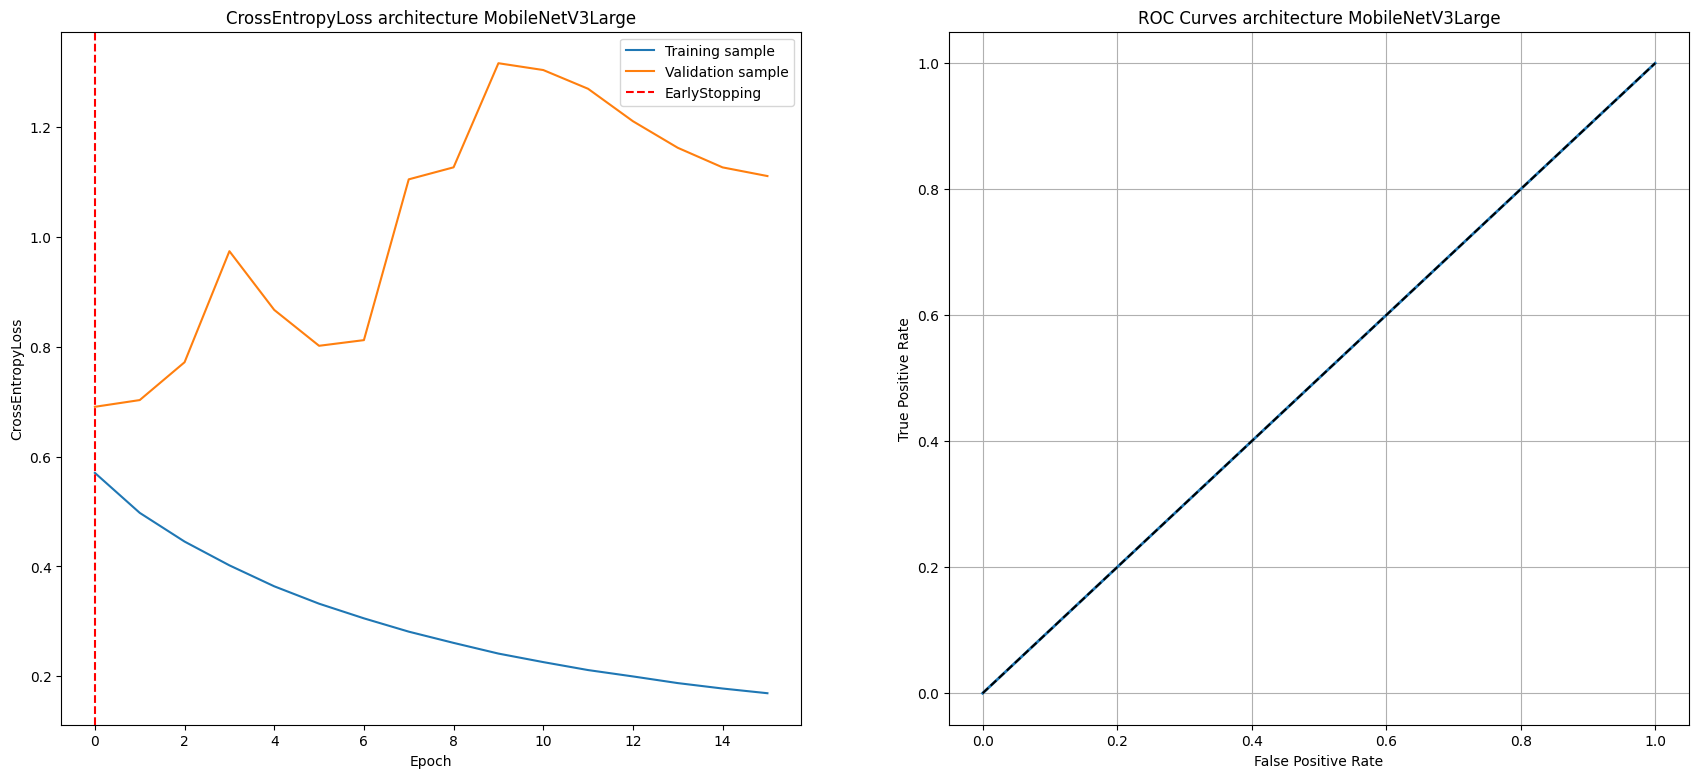

In [15]:
model = models.mobilenet_v3_large() # Загрузка структуры и весов
model.classifier = torch.nn.Linear(960, 2) # Замена слоя классификации
model.to(device)
name_model = 'MobileNetV3Large'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.3. Тренировка архитектуры нейросети EffecientNet_B0

Training of EffecientNet_B0 neural network architecture
[  1/100] loss train: 0.62572 | loss valid: 1.48870
Validation loss decreased (inf --> 1.48870).  Saving model ...
[  2/100] loss train: 0.56174 | loss valid: 0.99866
Validation loss decreased (1.48870 --> 0.99866).  Saving model ...
[  3/100] loss train: 0.52030 | loss valid: 0.81369
Validation loss decreased (0.99866 --> 0.81369).  Saving model ...
[  4/100] loss train: 0.49137 | loss valid: 0.73241
Validation loss decreased (0.81369 --> 0.73241).  Saving model ...
[  5/100] loss train: 0.45981 | loss valid: 0.67617
Validation loss decreased (0.73241 --> 0.67617).  Saving model ...
[  6/100] loss train: 0.43413 | loss valid: 0.61914
Validation loss decreased (0.67617 --> 0.61914).  Saving model ...
[  7/100] loss train: 0.40846 | loss valid: 0.58117
Validation loss decreased (0.61914 --> 0.58117).  Saving model ...
[  8/100] loss train: 0.38302 | loss valid: 0.54717
Validation loss decreased (0.58117 --> 0.54717).  Saving model 

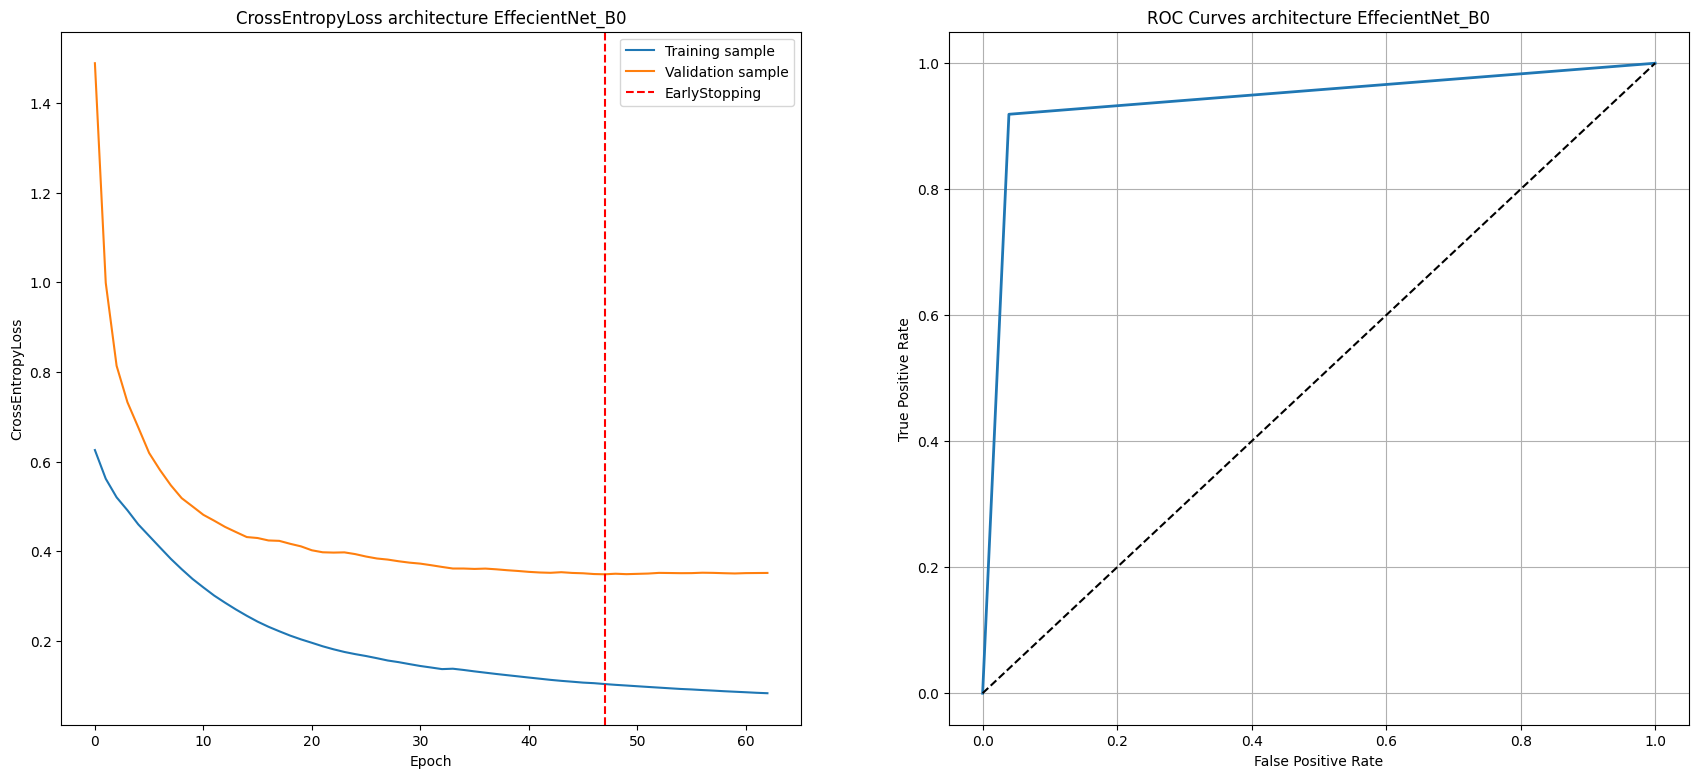

In [16]:
model = models.efficientnet_b0() # Загрузка структуры и весов
model.classifier = torch.nn.Linear(1280, 2) # Замена слоя классификации
model.to(device)
name_model = 'EffecientNet_B0'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.4. Тренировка архитектуры нейросети MNASNET1_3

Training of MNASNET1_3 neural network architecture
[  1/100] loss train: 0.56140 | loss valid: 0.68848
Validation loss decreased (inf --> 0.68848).  Saving model ...
[  2/100] loss train: 0.48325 | loss valid: 0.69031
EarlyStopping counter: 1 out of 15
[  3/100] loss train: 0.43724 | loss valid: 0.70801
EarlyStopping counter: 2 out of 15
[  4/100] loss train: 0.40273 | loss valid: 0.75650
EarlyStopping counter: 3 out of 15
[  5/100] loss train: 0.37293 | loss valid: 0.78529
EarlyStopping counter: 4 out of 15
[  6/100] loss train: 0.34402 | loss valid: 0.81794
EarlyStopping counter: 5 out of 15
[  7/100] loss train: 0.31721 | loss valid: 0.86197
EarlyStopping counter: 6 out of 15
[  8/100] loss train: 0.29489 | loss valid: 0.89506
EarlyStopping counter: 7 out of 15
[  9/100] loss train: 0.27470 | loss valid: 0.95407
EarlyStopping counter: 8 out of 15
[ 10/100] loss train: 0.25635 | loss valid: 1.02008
EarlyStopping counter: 9 out of 15
[ 11/100] loss train: 0.24104 | loss valid: 1.06630

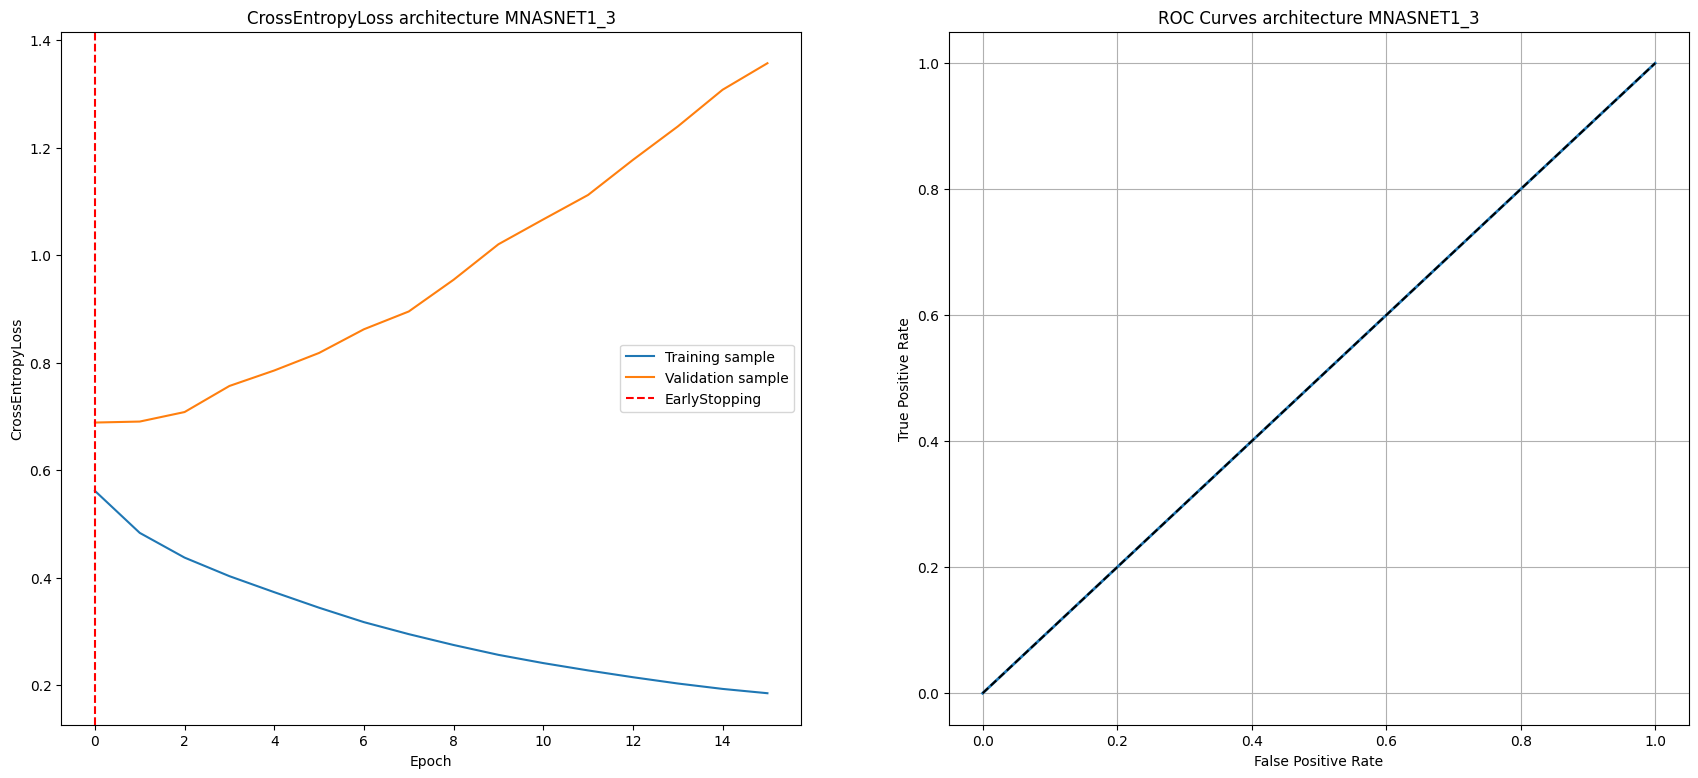

In [17]:
model = models.mnasnet1_3() # Загрузка структуры и весов
model.classifier = torch.nn.Linear(1280, 2) # Замена слоя классификации
model.to(device)
name_model = 'MNASNET1_3'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.5. Тренировка архитектуры нейросети ResNet18

Training of ResNet18 neural network architecture
[  1/100] loss train: 0.78573 | loss valid: 0.50876
Validation loss decreased (inf --> 0.50876).  Saving model ...
[  2/100] loss train: 0.62652 | loss valid: 0.63218
EarlyStopping counter: 1 out of 15
[  3/100] loss train: 0.55901 | loss valid: 0.59540
EarlyStopping counter: 2 out of 15
[  4/100] loss train: 0.51932 | loss valid: 0.59694
EarlyStopping counter: 3 out of 15
[  5/100] loss train: 0.48757 | loss valid: 0.59185
EarlyStopping counter: 4 out of 15
[  6/100] loss train: 0.46230 | loss valid: 0.57285
EarlyStopping counter: 5 out of 15
[  7/100] loss train: 0.44010 | loss valid: 0.54552
EarlyStopping counter: 6 out of 15
[  8/100] loss train: 0.42075 | loss valid: 0.53284
EarlyStopping counter: 7 out of 15
[  9/100] loss train: 0.40629 | loss valid: 0.52475
EarlyStopping counter: 8 out of 15
[ 10/100] loss train: 0.39210 | loss valid: 0.52175
EarlyStopping counter: 9 out of 15
[ 11/100] loss train: 0.37812 | loss valid: 0.51603
E

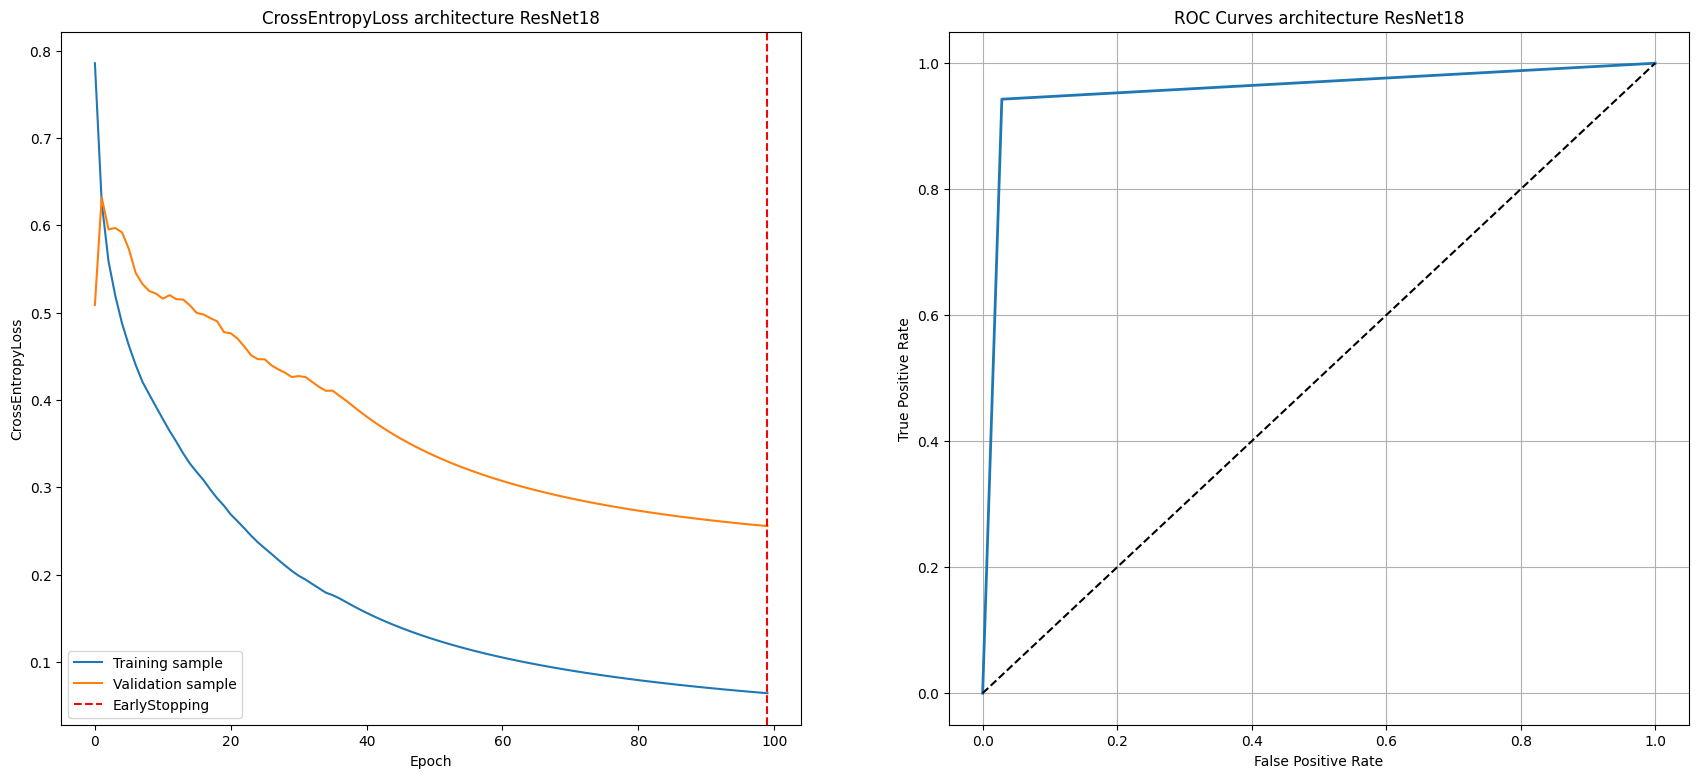

In [18]:
model = models.resnet18() # Загрузка структуры и весов
model.classifier = torch.nn.Linear(1000, 2) # Замена слоя классификации
model.to(device)
name_model = 'ResNet18'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

## 3.6. Тренировка архитектуры нейросети YOLOv8


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

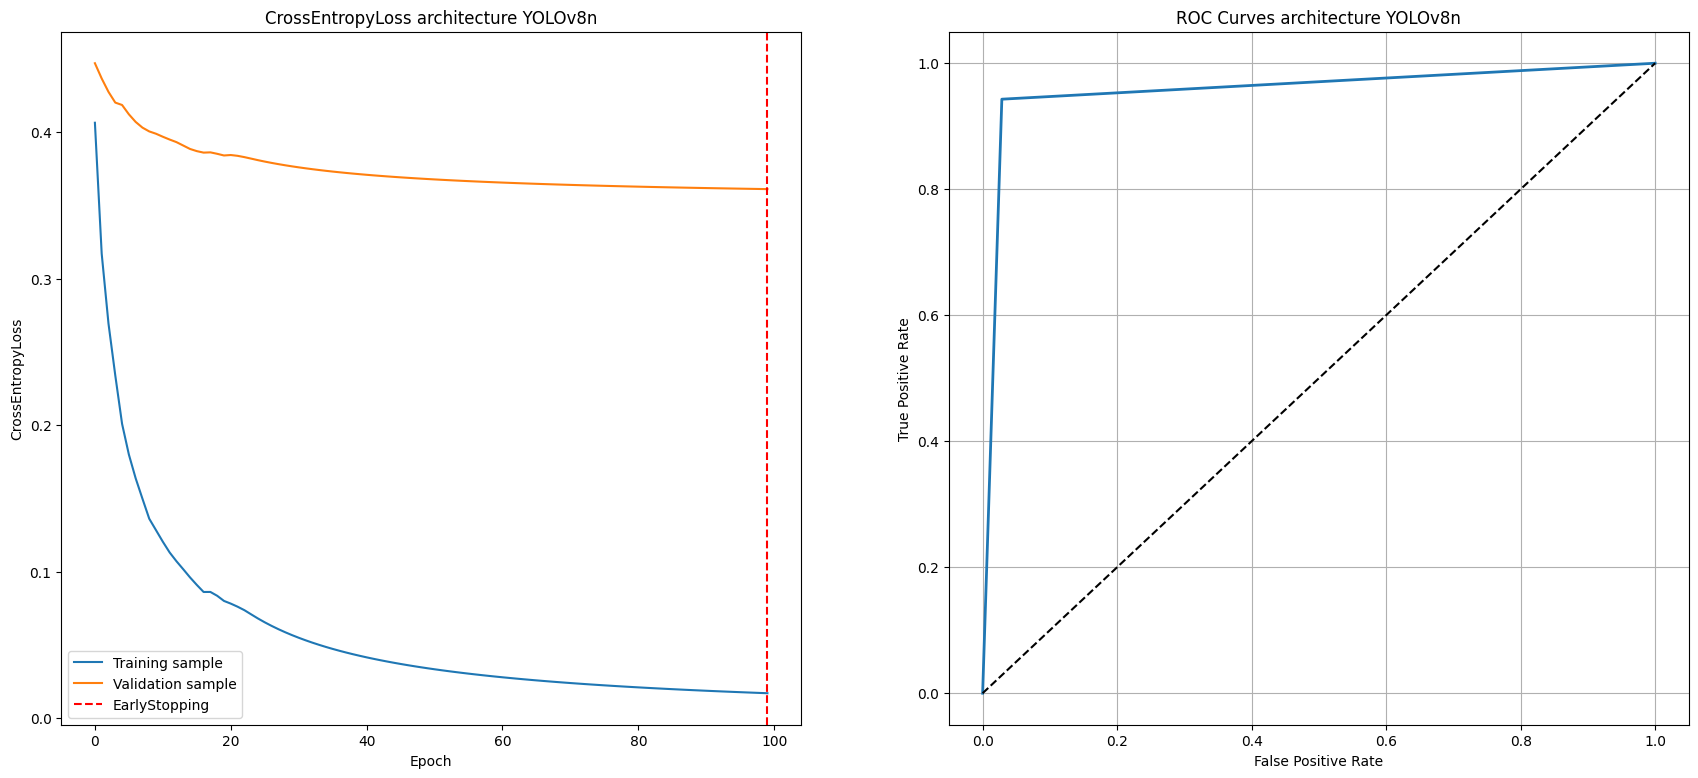

In [19]:
model = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')
model.model.model[-1].linear  = torch.nn.Linear(1280, 2) # Замена слоя классификации
model = model.model
model.to(device)
name_model = 'YOLOv8n'
roc, loss_history, epoch_erly_stopping, accuracy, loss  = trainNeuralNetwork(
    model, loaders, name_model, max_epochs_models, epoch_patience_models) 
addHistoryModels(name_model, roc, loss_history, accuracy, loss, epoch_erly_stopping)
visualizationLearning(name_model, epoch_erly_stopping, roc, loss_history)
del loss_history, epoch_erly_stopping, accuracy, loss, name_model, roc

# 4. Визуализация всех моделей на одном графике

In [4]:
def visualizationNeuralNetworks(data):
    '''
    Функция позволяет визуализировать точность моделей нейросетей на каждой из эпох и поместить всех их на один график
    Input:
        data - массив содержащий словари с данными по каждой нейросети
    '''
    plt.figure(figsize=(21, 9))
    max_epoch = 0
    for item in data:
        # Изображение истории ошибок
        plt.subplot(1, 2, 1)
        plt.plot(item['loss_history']['valid'], label=item['name'])
        plt.title('CrossEntropyLoss of neural networks')
        plt.xlabel('Epoch')
        plt.ylabel('CrossEntropyLoss')
        plt.legend()

        # Изображение ROC кривой
        plt.subplot(1, 2, 2)
        fpr, tpr, _ = roc_curve(item['roc_data']['correct'], item['roc_data']['preds'])
        plt.plot(fpr, tpr, linewidth=2, label=item['name'])
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.title('ROC Curves of neural networks')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend()
        plt.grid(True)
    
    plt.savefig(f'visualizationNeuralNetworks.png', dpi=100)
    plt.show()

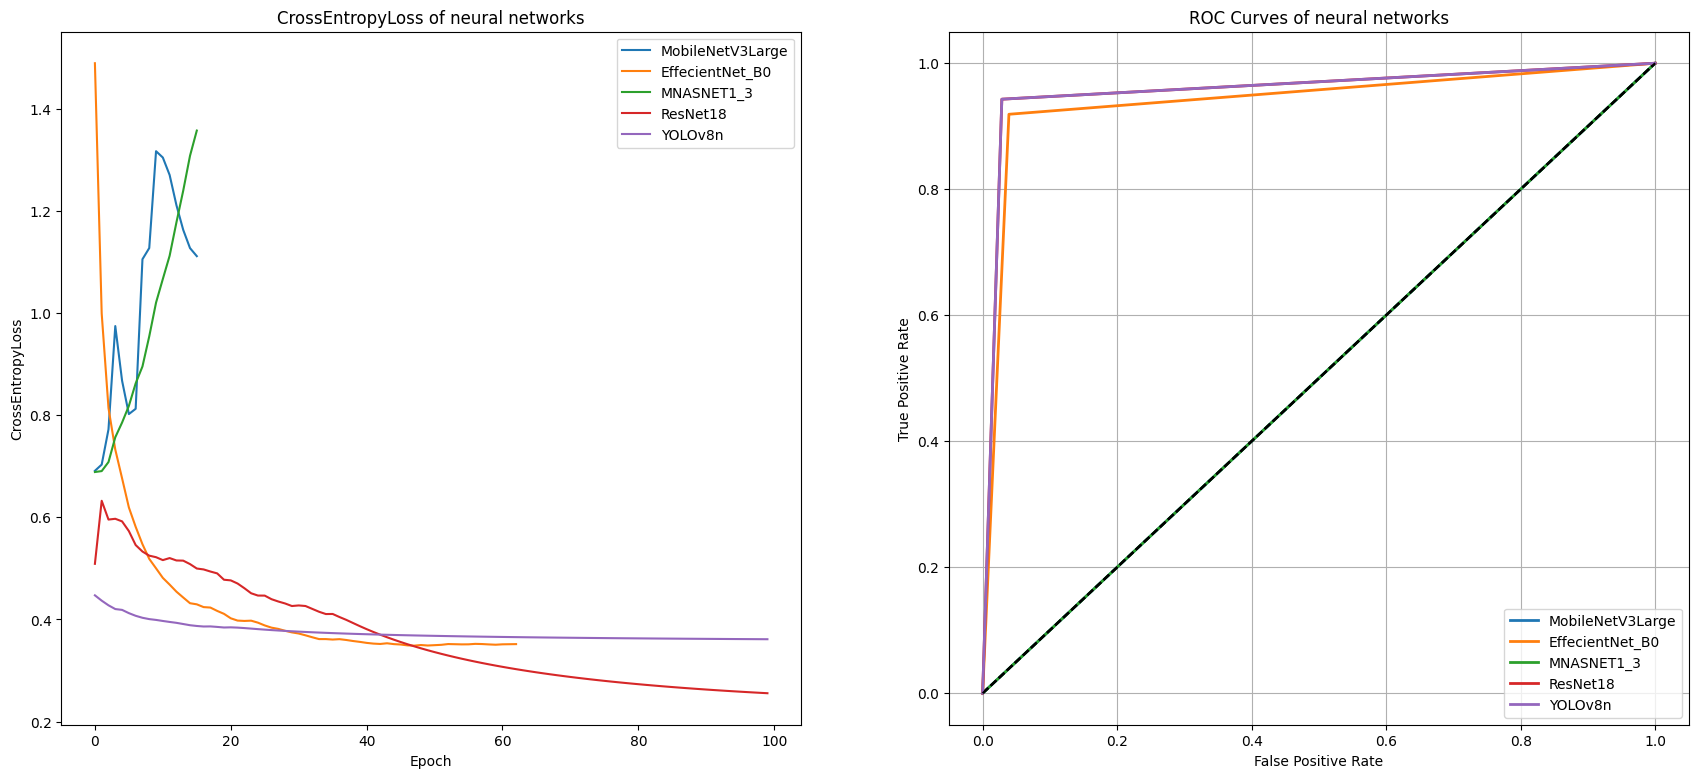

In [5]:
with open('data.json', 'r') as file:
    data = json.load(file)
visualizationNeuralNetworks(data)

По итогу обучения двух нейросетей видно, что у архитектур YOLO и ResNet имеют лучшие показатели на ROC кривой, но ResNet имеет наименьшую ошибку относительно YOLO, поэтому данную архитекутуру будем дообучать


# . Просмотр скорости работы нейросетей

In [ ]:
%%time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load('model121.pth').to(device)

In [ ]:
%%time
PATH = './Dataset/Spesial_car/0001.jpg' # Путь к фото
# Загрузка и обработка фото
X = []
src = cv2.imread(PATH, cv2.IMREAD_COLOR) 
dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
X.append(cv2.resize(dst, dsize=(200, 200), interpolation=cv2.INTER_AREA))
X = np.array(X)
X = X.astype('float32')
X = X / 255.0
X = X.reshape(-1,3,200,200)
X = torch.from_numpy(X).float().to(device)

# Модель ставим на predict и пропускаем
best_model.eval()
print(best_model(X).argmax(-1).item())

In [ ]:
%%time
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load('model169.pth').to(device)

In [ ]:
%%time
PATH = './Dataset/Spesial_car/0003.jpg' # Путь к фото
# Загрузка и обработка фото
X = []
src = cv2.imread(PATH, cv2.IMREAD_COLOR) 
dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB) 
X.append(cv2.resize(dst, dsize=(200, 200), interpolation=cv2.INTER_AREA))
X = np.array(X)
X = X.astype('float32')
X = X / 255.0
X = X.reshape(-1,3,200,200)
X = torch.from_numpy(X).float().to(device)

# Модель ставим на predict и пропускаем
best_model.eval()
print(best_model(X).argmax(-1).item())